In [2]:
pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 10.8 MB 3.1 MB/s            
     |████████████████████████████████| 232 kB 28.0 MB/s            
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 3.6 MB 3.1 MB/s            
Note: you may need to restart the kernel to use updated packages.


Hybrid SARIMA + LightGBM RMSE: 1157038.251


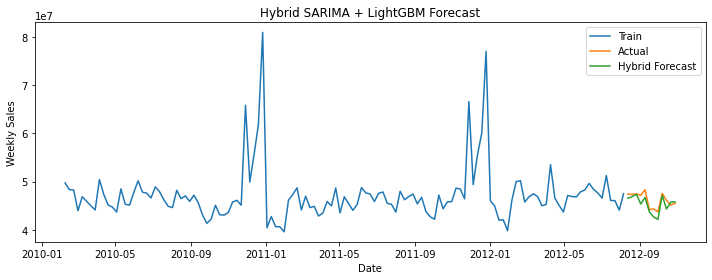

In [31]:
# ─── Hybrid SARIMA + LightGBM Forecast Template ───

# 0) Silence unwanted warnings & logs
import warnings, logging

# Only ignore the SARIMA “Too few observations…” warning
warnings.filterwarnings("ignore", message="Too few observations to estimate starting parameters")

# Suppress all other UserWarnings (optional)
warnings.filterwarnings("ignore", category=UserWarning)

# Only show LightGBM errors
logging.getLogger("lightgbm").setLevel(logging.ERROR)

# 1) Imports
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 2) Load your files (adjust paths if needed)
train    = pd.read_csv('train.csv',    parse_dates=['Date'])
features = pd.read_csv('features.csv', parse_dates=['Date'])
stores   = pd.read_csv('stores.csv')
test     = pd.read_csv('test.csv',     parse_dates=['Date'])

# 3) Merge & rename
df = (
    train
    .merge(features, on=['Store','Date'], how='left')
    .merge(stores,  on='Store',        how='left')
    .rename(columns={'Weekly_Sales':'sales'})
)

# 4) Aggregate to weekly totals (Monday boundary)
weekly = df.groupby('Date')['sales'].sum().resample('W-MON').sum()

# 5) Split off last 12 weeks for testing
train_ts = weekly.iloc[:-12]
test_ts  = weekly.iloc[-12:]

# 6) Fit SARIMA (captures trend + 52-week seasonality)
sarima = SARIMAX(
    train_ts,
    order=(1,1,1),
    seasonal_order=(1,1,1,52),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

sarima_pred = sarima.get_forecast(len(test_ts)).predicted_mean
residuals   = train_ts - sarima.fittedvalues

# 7) Feature builder for residual model
def make_feats(ts):
    df = pd.DataFrame({'y': ts})
    df['lag1']   = df['y'].shift(1)
    df['lag52']  = df['y'].shift(52)
    df['roll3']  = df['y'].rolling(3).mean().shift(1)
    df['month']  = df.index.month
    return df.dropna()

# Prepare training features & target
feat_train = make_feats(residuals)
X_res, y_res = feat_train.drop(columns='y'), feat_train['y']

# 8) Train LightGBM on the residuals (silent mode)
lgb = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=32,
    random_state=42,
    verbosity=-1
)
lgb.fit(X_res, y_res)  # no verbose flag here

# 9) Forecast residuals for the test period
full_ts   = pd.concat([train_ts, test_ts*0])
full_feat = make_feats(full_ts)

# Keep exactly the same feature columns
X_test_res = full_feat.loc[test_ts.index, X_res.columns]
res_pred   = lgb.predict(X_test_res)

# 10) Combine & evaluate
hybrid_pred = sarima_pred.values + res_pred
mse   = mean_squared_error(test_ts, hybrid_pred)
rmse  = np.sqrt(mse)
print(f'Hybrid SARIMA + LightGBM RMSE: {rmse:.3f}')

# 11) Plot
plt.figure(figsize=(10,4))
plt.plot(train_ts.index, train_ts,            label='Train')
plt.plot(test_ts.index,  test_ts,             label='Actual')
plt.plot(test_ts.index,  hybrid_pred,          label='Hybrid Forecast')
plt.legend()
plt.title('Hybrid SARIMA + LightGBM Forecast')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.tight_layout()
plt.show()


In [32]:
# ─── Revised Step 3: Data Preprocessing / Cleaning ───

import pandas as pd
from sklearn.preprocessing import StandardScaler

# 1) Load
train    = pd.read_csv('train.csv',    parse_dates=['Date'])
features = pd.read_csv('features.csv', parse_dates=['Date'])
stores   = pd.read_csv('stores.csv')

# 2) Merge & rename
df = (
    train
    .merge(features, on=['Store','Date'], how='left')
    .merge(stores,  on='Store',        how='left')
    .rename(columns={'Weekly_Sales':'sales'})
)

# 3) Drop the extra IsHoliday and keep only the train’s
df = df.drop(columns=['IsHoliday_y']).rename(columns={'IsHoliday_x':'IsHoliday'})

# 4) Report missing
print("Missing per column before fill:\n", df.isna().sum(), "\n")

# 5) Fill Markdown nulls with 0
md_cols = [f'MarkDown{i}' for i in range(1,6)]
for c in md_cols:
    # assign back to avoid chained-assignment
    df[c] = df[c].fillna(0)

# 6) Fill other numeric nulls with median
num_cols = df.select_dtypes(include='number').columns.drop('sales')
for c in num_cols:
    if c not in md_cols:
        df[c] = df[c].fillna(df[c].median())

# 7) Fill any remaining categorical nulls
cat_cols = ['Type','Size']
for c in cat_cols:
    df[c] = df[c].fillna('Unknown').astype('category')

# 8) Convert boolean
df['IsHoliday'] = df['IsHoliday'].astype(bool)

# 9) Drop duplicates
before = len(df)
df = df.drop_duplicates()
print(f"Dropped {before - len(df)} duplicates\n")

# 10) Standardize numeric predictors
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# 11) One-hot encode small categorical features
df = pd.get_dummies(df, columns=['Type','Size'], drop_first=True)

# 12) Final check
print("Missing per column after fill:\n", df.isna().sum(), "\n")
print("Final shape and dtypes:\n", df.shape, df.dtypes, "\n")
df.head()


Missing per column before fill:
 Store                0
Dept                 0
Date                 0
sales                0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Type                 0
Size                 0
dtype: int64 

Dropped 0 duplicates

Missing per column after fill:
 Store                        0
Dept                         0
Date                         0
sales                        0
IsHoliday                    0
Temperature                  0
Fuel_Price                   0
MarkDown1                    0
MarkDown2                    0
MarkDown3                    0
MarkDown4                    0
MarkDown5                    0
CPI                          0
Unemployment                 0
Type_B                       0
Type_C                       0
Size_-1.6289780801400044     0
Siz

,Store,Dept,Date,sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Size_1.0786574789203154,Size_1.0868896172174107,Size_1.0989426483894524,Size_1.0990738378443863,Size_1.10020534689319,Size_1.1061908657745443,Size_1.133724252628773,Size_1.1409232739682647,Size_1.1605524961627327,Size_1.3593537164330218
0,-1.658199,-1.418742,2010-02-05,24924.50,False,-0.963798,-1.720834,-0.427943,-0.173069,-0.084662,...,False,False,False,False,False,False,False,False,False,False
1,-1.658199,-1.418742,2010-02-12,46039.49,True,-1.169783,-1.773177,-0.427943,-0.173069,-0.084662,...,False,False,False,False,False,False,False,False,False,False
2,-1.658199,-1.418742,2010-02-19,41595.55,False,-1.092810,-1.847330,-0.427943,-0.173069,-0.084662,...,False,False,False,False,False,False,False,False,False,False
3,-1.658199,-1.418742,2010-02-26,19403.54,False,-0.729625,-1.744825,-0.427943,-0.173069,-0.084662,...,False,False,False,False,False,False,False,False,False,False
4,-1.658199,-1.418742,2010-03-05,21827.90,False,-0.736672,-1.605243,-0.427943,-0.173069,-0.084662,...,False,False,False,False,False,False,False,False,False,False


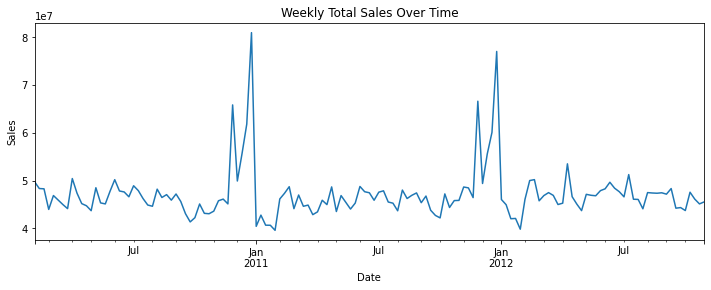

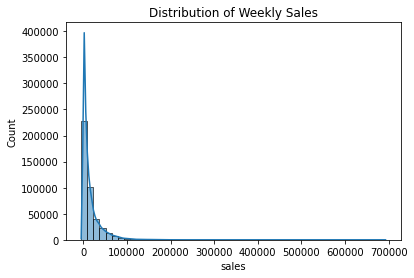

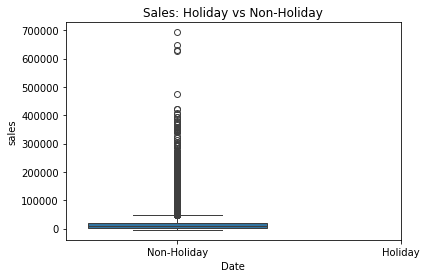

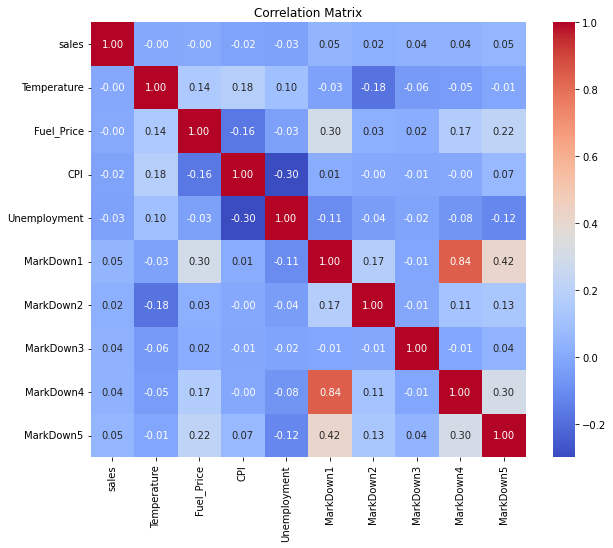

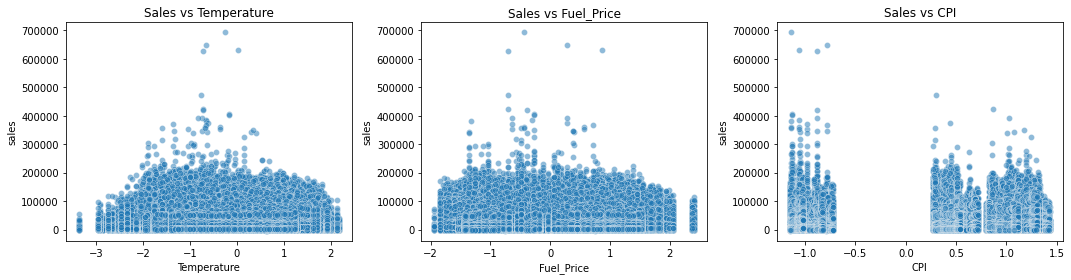

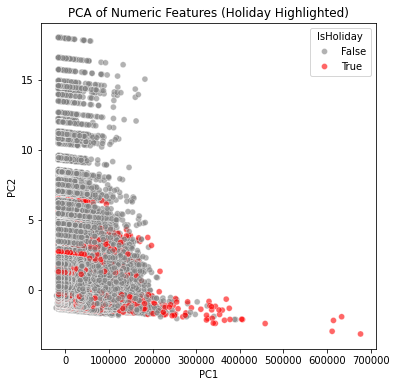

In [33]:
# ─── Full Step 3 + Step 4: Preprocessing & EDA ───

# 0) Imports & warning suppression (optional)
import warnings, logging
warnings.filterwarnings("ignore", message="Too few observations to estimate starting parameters")
warnings.filterwarnings("ignore", category=UserWarning)
logging.getLogger("lightgbm").setLevel(logging.ERROR)

# 1) Preprocessing / Cleaning (revised Step 3)
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load raw data
train    = pd.read_csv('train.csv',    parse_dates=['Date'])
features = pd.read_csv('features.csv', parse_dates=['Date'])
stores   = pd.read_csv('stores.csv')

# Merge & rename
df = (
    train
    .merge(features, on=['Store','Date'], how='left')
    .merge(stores,  on='Store',        how='left')
    .rename(columns={'Weekly_Sales':'sales'})
)

# Drop duplicate holiday flag
df = df.drop(columns=['IsHoliday_y']).rename(columns={'IsHoliday_x':'IsHoliday'})

# Fill Markdown nulls with 0
for c in [f'MarkDown{i}' for i in range(1,6)]:
    df[c] = df[c].fillna(0)

# Fill other numeric nulls with median
num_cols = df.select_dtypes(include='number').columns.drop('sales')
for c in num_cols:
    if 'MarkDown' not in c:
        df[c] = df[c].fillna(df[c].median())

# Fill categorical nulls and cast
for c in ['Type','Size']:
    df[c] = df[c].fillna('Unknown').astype('category')

# Cast holiday to bool
df['IsHoliday'] = df['IsHoliday'].astype(bool)

# Drop duplicates
df = df.drop_duplicates()

# Standardize numeric predictors
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# One-hot encode Type & Size
df = pd.get_dummies(df, columns=['Type','Size'], drop_first=True)

# 2) Exploratory Data Analysis (Step 4)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Ensure Date is index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# 4.1 Time-series of weekly sales
plt.figure(figsize=(12,4))
df['sales'].resample('W-MON').sum().plot()
plt.title("Weekly Total Sales Over Time")
plt.ylabel("Sales")
plt.show()

# 4.2 Distribution of sales
plt.figure(figsize=(6,4))
sns.histplot(df['sales'], bins=50, kde=True)
plt.title("Distribution of Weekly Sales")
plt.show()

# 4.3 Sales on Holiday vs Non-Holiday
plt.figure(figsize=(6,4))
sns.boxplot(x=df.index.to_series().dt.weekday==6, y=df['sales'])
plt.xticks([0,1], ['Non-Holiday','Holiday'])
plt.title("Sales: Holiday vs Non-Holiday")
plt.show()

# 4.4 Correlation heatmap of key numerics
num_feats = ['sales','Temperature','Fuel_Price','CPI','Unemployment'] + [f'MarkDown{i}' for i in range(1,6)]
plt.figure(figsize=(10,8))
sns.heatmap(df[num_feats].corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Matrix")
plt.show()

# 4.5 Scatterplots: sales vs key drivers
fig, axes = plt.subplots(1,3, figsize=(15,4))
for ax, col in zip(axes, ['Temperature','Fuel_Price','CPI']):
    sns.scatterplot(x=df[col], y=df['sales'], ax=ax, alpha=0.5)
    ax.set_title(f"Sales vs {col}")
plt.tight_layout()
plt.show()

# 4.6 PCA on numeric features
X = df[num_feats].fillna(0)
pca = PCA(n_components=2)
pcs = pca.fit_transform(X)
pc_df = pd.DataFrame(pcs, columns=['PC1','PC2'], index=df.index)

plt.figure(figsize=(6,6))
sns.scatterplot(x='PC1', y='PC2', hue=df['IsHoliday'], data=pc_df, palette=['gray','red'], alpha=0.6)
plt.title("PCA of Numeric Features (Holiday Highlighted)")
plt.show()


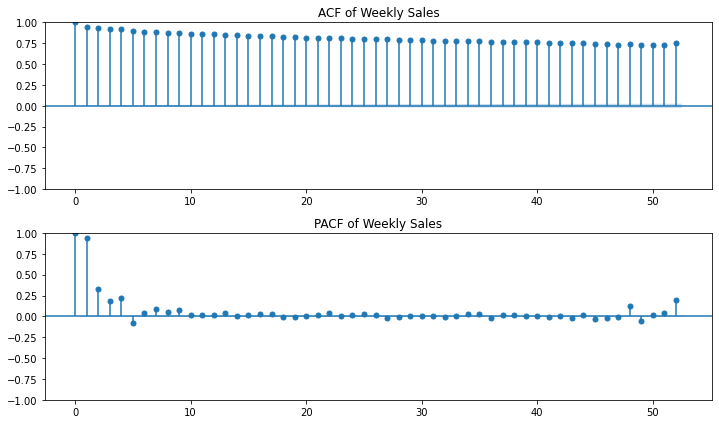

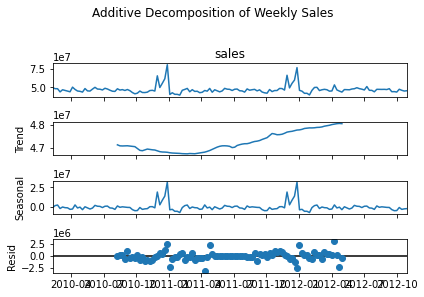

/scratch/tvadde/6336809/ipykernel_3164762/126897901.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df['sales'].resample('M').sum()


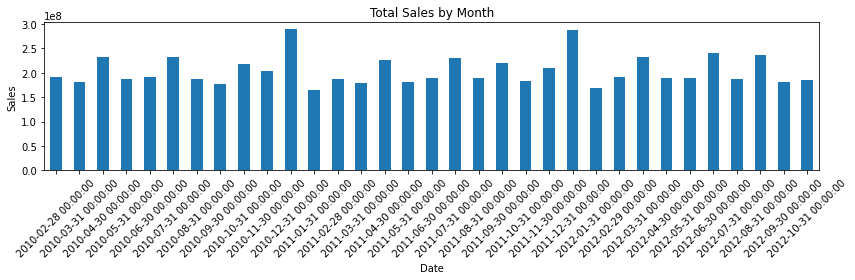

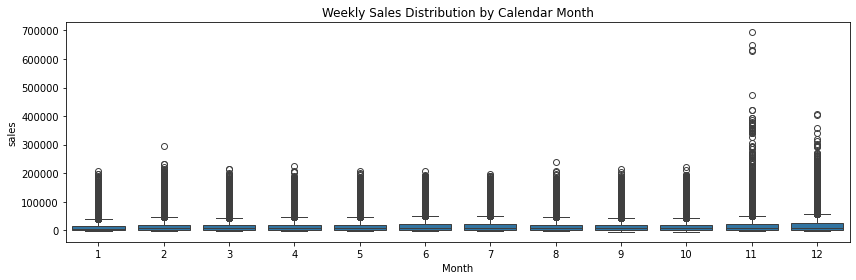

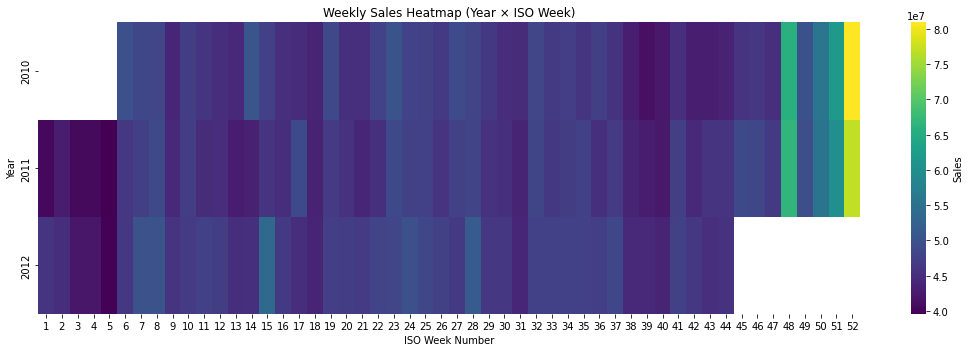

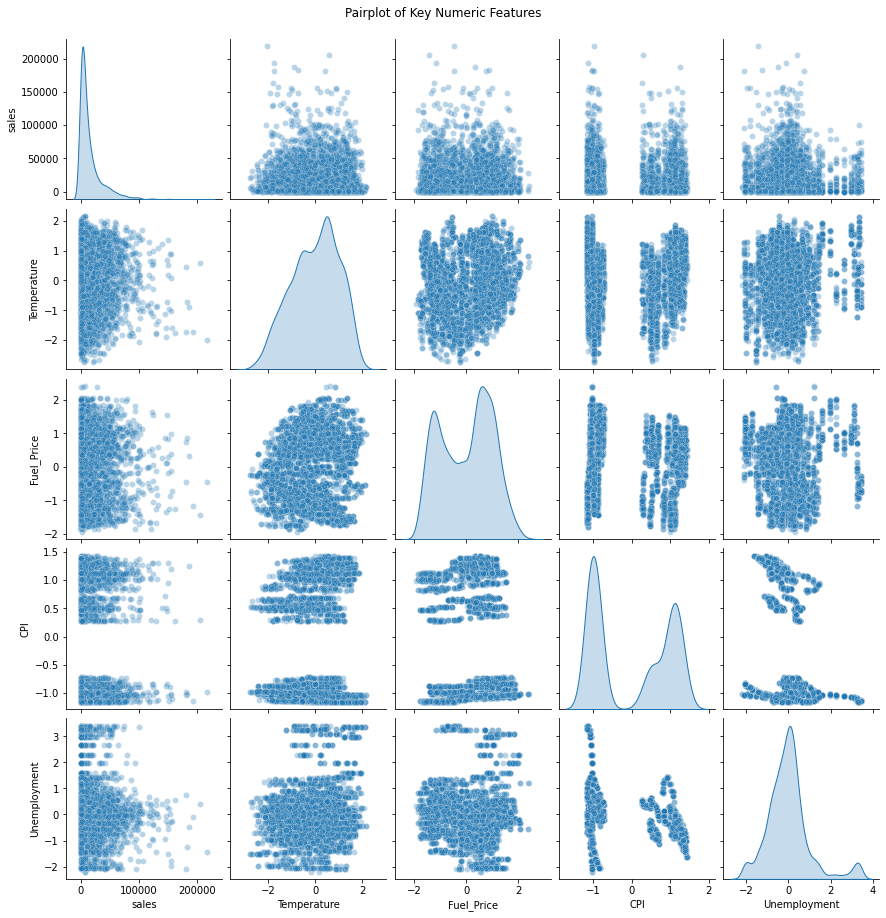

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# 1) ACF & PACF to expose autocorrelation structure
fig, axes = plt.subplots(2,1, figsize=(10,6))
plot_acf(df['sales'], lags=52, ax=axes[0])
axes[0].set_title("ACF of Weekly Sales")
plot_pacf(df['sales'], lags=52, ax=axes[1])
axes[1].set_title("PACF of Weekly Sales")
plt.tight_layout()
plt.show()

# 2) Seasonal Decomposition (additive)
decomp = seasonal_decompose(df['sales'].resample('W-MON').sum(), model='additive')
decomp.plot()
plt.suptitle("Additive Decomposition of Weekly Sales", y=1.02)
plt.tight_layout()
plt.show()

# 3) Monthly Sales Bar Chart
monthly = df['sales'].resample('M').sum()
plt.figure(figsize=(12,4))
monthly.plot(kind='bar')
plt.title("Total Sales by Month")
plt.ylabel("Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4) Sales Distribution by Month (boxplot)
df_month = df.copy()
df_month['month'] = df_month.index.month
plt.figure(figsize=(12,4))
sns.boxplot(x='month', y='sales', data=df_month)
plt.title("Weekly Sales Distribution by Calendar Month")
plt.xlabel("Month")
plt.tight_layout()
plt.show()

# 5) Weekly Heatmap: Year vs ISO-Week
weekly = df['sales'].resample('W-MON').sum().to_frame()
weekly['year'] = weekly.index.year
weekly['week'] = weekly.index.isocalendar().week
pivot = weekly.pivot(index='year', columns='week', values='sales')
plt.figure(figsize=(15,5))
sns.heatmap(pivot, cmap='viridis', cbar_kws={'label':'Sales'})
plt.title("Weekly Sales Heatmap (Year × ISO Week)")
plt.ylabel("Year")
plt.xlabel("ISO Week Number")
plt.tight_layout()
plt.show()

# 6) Pairplot of Core Numeric Features (sampled)
sample = df.sample(5000, random_state=42)
sns.pairplot(
    sample[['sales','Temperature','Fuel_Price','CPI','Unemployment']],
    diag_kind='kde',
    plot_kws={'alpha':0.3}
)
plt.suptitle("Pairplot of Key Numeric Features", y=1.02)
plt.show()


In [35]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 1) Load & merge
train    = pd.read_csv('train.csv',    parse_dates=['Date'])
features = pd.read_csv('features.csv', parse_dates=['Date'])
stores   = pd.read_csv('stores.csv')

df = (
    train
    .merge(features, on=['Store','Date'], how='left')
    .merge(stores,  on='Store',        how='left')
    .rename(columns={'Weekly_Sales':'sales'})
)
df = df.drop(columns=['IsHoliday_y']) \
       .rename(columns={'IsHoliday_x':'IsHoliday'})

# 2) Fill markdowns & other nulls
for c in [f'MarkDown{i}' for i in range(1,6)]:
    df[c] = df[c].fillna(0)
num_cols = df.select_dtypes('number').columns.drop('sales')
for c in num_cols:
    if 'MarkDown' not in c:
        df[c] = df[c].fillna(df[c].median())

# 3) Cast and encode
df['IsHoliday'] = df['IsHoliday'].astype(bool)
for c in ['Type','Size']:
    df[c] = df[c].fillna('Unknown').astype('category')
df = df.drop_duplicates()
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
df = pd.get_dummies(df, columns=['Type','Size'], drop_first=True)

# 4) Set index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

print("df ready:", df.shape)


df ready: (421570, 54)


In [36]:
import numpy as np

fe = df.copy()  # work on a copy so df stays intact

# Time components
fe['year']       = fe.index.year
fe['month']      = fe.index.month
fe['weekofyear'] = fe.index.isocalendar().week.astype(int)
fe['dayofweek']  = fe.index.dayofweek

# Cyclical encodings
fe['sin_month'] = np.sin(2*np.pi*fe['month']/12)
fe['cos_month'] = np.cos(2*np.pi*fe['month']/12)
fe['sin_week']  = np.sin(2*np.pi*fe['weekofyear']/52)
fe['cos_week']  = np.cos(2*np.pi*fe['weekofyear']/52)

print("Time & cyclical done:", fe.shape)


Time & cyclical done: (421570, 62)


In [37]:
# Lag features
for lag in [1,2,3,4,12]:
    fe[f'sales_lag_{lag}'] = fe['sales'].shift(lag)

# Rolling windows
fe['sales_roll_4']  = fe['sales'].rolling(4).mean().shift(1)
fe['sales_roll_12'] = fe['sales'].rolling(12).mean().shift(1)

print("Lag & rolling done:", fe.shape)


Lag & rolling done: (421570, 69)


In [38]:
# ─── Cell D: Holiday Proximity & Store/Dept Aggregates ───
import numpy as np

# assume `fe` exists with DateTimeIndex and columns 'sales' & 'IsHoliday'
fe = fe.copy()

# 1) Vectorized holiday‐proximity
# --------------------------------
# Extract sorted array of holiday dates
holidays = fe.index[fe['IsHoliday']].to_numpy()

# Array of all dates
dates = fe.index.to_numpy()

# Next‐holiday calculation
# find insertion point, mask out‐of‐bounds
idx_next = np.searchsorted(holidays, dates, side='right')
days_to = np.full(len(dates), 999, dtype=int)
mask = idx_next < len(holidays)
days_to[mask] = (
    (holidays[idx_next[mask]] - dates[mask])
    .astype('timedelta64[D]')
    .astype(int)
)

# Previous‐holiday calculation
idx_prev = np.searchsorted(holidays, dates, side='right') - 1
idx_prev = np.clip(idx_prev, 0, len(holidays)-1)
days_since = (
    (dates - holidays[idx_prev])
    .astype('timedelta64[D]')
    .astype(int)
)

fe['days_to_holiday']   = days_to
fe['days_since_holiday'] = days_since

# 2) Store‐level historical aggregates
# ------------------------------------
store_stats = fe.groupby('Store')['sales'].agg(
    store_avg='mean',
    store_std='std'
)
fe = fe.join(store_stats, on='Store')

# 3) Dept‐level historical aggregates
# -----------------------------------
dept_stats = fe.groupby('Dept')['sales'].agg(
    dept_avg='mean',
    dept_std='std'
)
fe = fe.join(dept_stats, on='Dept')

# 4) Clean‐up & preview
# ---------------------
# No need to dropna here (we haven’t shifted anything new)
print("Holiday proximity and aggregate features added:")
print(fe[['days_to_holiday','days_since_holiday','store_avg','store_std','dept_avg','dept_std']].head())


Holiday proximity and aggregate features added:
            days_to_holiday  days_since_holiday     store_avg     store_std  \
Date                                                                          
2010-02-05                7                  -7  21710.543621  27748.945511   
2010-02-12              210                   0  21710.543621  27748.945511   
2010-02-19              203                   7  21710.543621  27748.945511   
2010-02-26              196                  14  21710.543621  27748.945511   
2010-03-05              189                  21  21710.543621  27748.945511   

                dept_avg      dept_std  
Date                                    
2010-02-05  19213.485088  15102.373853  
2010-02-12  19213.485088  15102.373853  
2010-02-19  19213.485088  15102.373853  
2010-02-26  19213.485088  15102.373853  
2010-03-05  19213.485088  15102.373853  


In [39]:
# ─── Step 6: Model Selection & Training ───

import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error

# 1) Prepare X, y from your engineered DataFrame `fe`
#    (make sure `fe` still has your features + 'sales' and DateIndex)
X = fe.drop(columns=['sales'])
y = fe['sales']

# 2) TimeSeries split
tscv = TimeSeriesSplit(n_splits=5)

# 3) Train & evaluate LightGBM baseline
rmse_scores = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(X), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model = LGBMRegressor(
        n_estimators=500,
        learning_rate=0.05,
        num_leaves=32,
        random_state=42,
        verbosity=-1
    )
    model.fit(X_train, y_train)
    
    preds = model.predict(X_val)
    rmse  = np.sqrt(mean_squared_error(y_val, preds))
    print(f'Fold {fold:>2} RMSE: {rmse:.0f}')
    rmse_scores.append(rmse)

print(f'\nAverage CV RMSE: {np.mean(rmse_scores):.0f}')

# 4) (Optional) Quick hyperparameter grid‐search on one fold
param_grid = {
    'num_leaves':    [16, 32],
    'learning_rate': [0.01, 0.05],
    'n_estimators':  [200, 500]
}
gsearch = GridSearchCV(
    LGBMRegressor(random_state=42, verbosity=-1),
    param_grid,
    cv=TimeSeriesSplit(n_splits=3),
    scoring='neg_mean_squared_error',
    n_jobs=2
)
gsearch.fit(X.iloc[:2000], y.iloc[:2000])  # demo on a subset
print("\nBest params:", gsearch.best_params_)


Fold  1 RMSE: 5673
Fold  2 RMSE: 3747
Fold  3 RMSE: 3757
Fold  4 RMSE: 3904
Fold  5 RMSE: 2647

Average CV RMSE: 3946

Best params: {'learning_rate': 0.05, 'n_estimators': 200, 'num_leaves': 32}


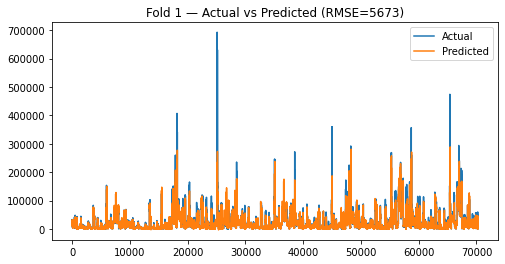

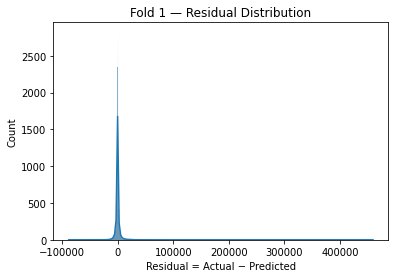

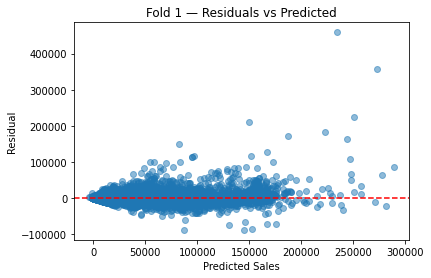

Fold 1 RMSE: 5673.00


In [40]:
# Step 7.1: Residual Analysis for a Single CV Fold

# 1) Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

# 2) Prepare your feature matrix X and target y (from Step 5)
#    and define the same TimeSeriesSplit you used before.
#    (If they’re not in memory, re-create `fe`, then:)
# fe = ...  # your engineered DataFrame
# X = fe.drop(columns=['sales'])
# y = fe['sales']
tscv = TimeSeriesSplit(n_splits=5)

# 3) Choose which fold to inspect
fold_number = 1

# 4) Loop through the CV splits until you reach that fold
for fold_index, (train_idx, val_idx) in enumerate(tscv.split(X), start=1):
    if fold_index != fold_number:
        continue

    # a) Split data
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # b) Train a fresh LightGBM model
    model = LGBMRegressor(
        n_estimators=500,
        learning_rate=0.05,
        num_leaves=32,
        random_state=42,
        verbosity=-1
    )
    model.fit(X_train, y_train)

    # c) Predict on the validation slice
    preds     = model.predict(X_val)
    residuals = y_val - preds
    rmse      = np.sqrt(mean_squared_error(y_val, preds))

    # d) Plot Actual vs Predicted
    plt.figure(figsize=(8,4))
    plt.plot(y_val.values, label='Actual')
    plt.plot(preds,         label='Predicted')
    plt.title(f'Fold {fold_number} — Actual vs Predicted (RMSE={rmse:.0f})')
    plt.legend()
    plt.show()

    # e) Plot Residual Distribution
    plt.figure(figsize=(6,4))
    sns.histplot(residuals, kde=True)
    plt.title(f'Fold {fold_number} — Residual Distribution')
    plt.xlabel('Residual = Actual − Predicted')
    plt.show()

    # f) Plot Residuals vs Fitted Values
    plt.figure(figsize=(6,4))
    plt.scatter(preds, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'Fold {fold_number} — Residuals vs Predicted')
    plt.xlabel('Predicted Sales')
    plt.ylabel('Residual')
    plt.show()

    # g) Print the fold RMSE
    print(f"Fold {fold_number} RMSE: {rmse:.2f}")


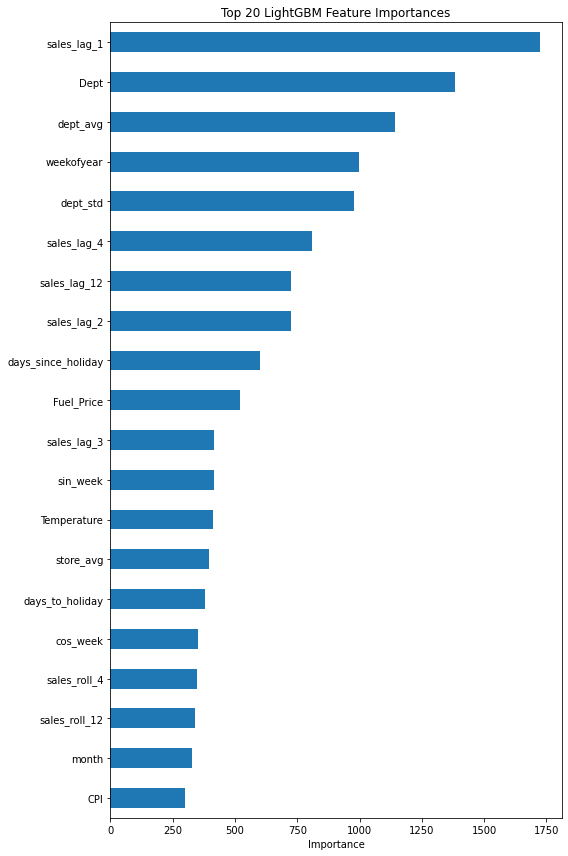

In [41]:
# ─── Step 7.2: Feature Importances & SHAP Explanations ───

# 1) Train a final LightGBM model on all data
from lightgbm import LGBMRegressor

model_full = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=32,
    random_state=42,
    verbosity=-1
)
model_full.fit(X, y)

# 2) Extract and plot the top 20 feature importances
import pandas as pd
import matplotlib.pyplot as plt

feat_imp = pd.Series(
    model_full.feature_importances_, 
    index=X.columns
).sort_values()

plt.figure(figsize=(8, 12))
feat_imp.tail(20).plot(kind='barh')
plt.title("Top 20 LightGBM Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# 3) (Optional) SHAP summary plot for deeper insights
#    Uncomment the following if you have shap installed:
#
# import shap
# explainer   = shap.TreeExplainer(model_full)
# shap_values = explainer.shap_values(X)
# shap.summary_plot(shap_values, X, max_display=20)


In [42]:
X_train = train2.drop(columns=['sales','is_train','Date','ID'], errors='ignore')
X_test  = test2 .drop(columns=['sales','is_train','Date','ID'], errors='ignore')


In [43]:
# 9) Split back into train/test
train2 = full[full.is_train]
test2  = full[~full.is_train]

# 10) Drop unneeded cols, ignoring missing labels
X_train = train2.drop(columns=['sales','is_train','Date','ID'], errors='ignore')
y_train = train2['sales']

X_test  = test2 .drop(columns=['sales','is_train','Date','ID'], errors='ignore')

# Check shapes
print("X_train shape:", X_train.shape)
print("X_test  shape:", X_test.shape)


X_train shape: (421558, 74)
X_test  shape: (0, 74)


In [44]:
# 9a) Split full into train2/test2
train2 = full[full.is_train].copy()
test2  = full[~full.is_train].copy()

# 9b) Drop NaNs ONLY from train2 (so lags/rolls are valid)
train2 = train2.dropna().reset_index(drop=True)

# 9c) Sanity check shapes
print("▶️ full:",   full.shape)
print("▶️ train2:", train2.shape)
print("▶️ test2: ", test2.shape)

# If test2 is (0, …), something upstream has removed all test rows.
# You should see test2.shape[0] == original_test_rows (e.g. len(test.csv)).


▶️ full: (421558, 77)
▶️ train2: (421558, 77)
▶️ test2:  (0, 77)


In [4]:
# 1. Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor

# Optional: install xgboost if not present
try:
    from xgboost import XGBRegressor
except ImportError:
    !pip install --user xgboost
    from xgboost import XGBRegressor

# 2. Load Data
train    = pd.read_csv('train.csv',    parse_dates=['Date'])
features = pd.read_csv('features.csv', parse_dates=['Date'])
stores   = pd.read_csv('stores.csv')
test     = pd.read_csv('test.csv',     parse_dates=['Date'])

# 3. Merge and mark train/test
def merge_all(df):
    return (
        df
        .merge(features, on=['Store','Date'], how='left')
        .merge(stores,  on='Store', how='left')
    )

train = merge_all(train).rename(columns={'Weekly_Sales': 'sales'})
test  = merge_all(test)
train['is_train'] = True
test['is_train']  = False
test['sales']     = np.nan

full = pd.concat([train, test], ignore_index=True)

# 4. Clean and encode
if 'IsHoliday_y' in full.columns:
    full = full.drop(columns=['IsHoliday_y']).rename(columns={'IsHoliday_x': 'IsHoliday'})

md_cols = [f'MarkDown{i}' for i in range(1, 6)]
for c in md_cols:
    full[c] = full[c].fillna(0)

num_cols = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
for c in num_cols:
    median = full.loc[full.is_train, c].median()
    full[c] = full[c].fillna(median)

full['IsHoliday'] = full['IsHoliday'].astype(bool)
full['Type']      = full['Type'].fillna('Unknown').astype('category')
full['Size']      = full['Size'].fillna('Unknown').astype('category')

scaler = StandardScaler()
full[num_cols] = scaler.fit_transform(full[num_cols])
full = pd.get_dummies(full, columns=['Type', 'Size'], drop_first=True)

# 5. Feature Engineering
full['year']       = full['Date'].dt.year
full['month']      = full['Date'].dt.month
full['weekofyear'] = full['Date'].dt.isocalendar().week.astype(int)
full['dayofweek']  = full['Date'].dt.dayofweek
full['sin_month']  = np.sin(2 * np.pi * full['month'] / 12)
full['cos_month']  = np.cos(2 * np.pi * full['month'] / 12)
full['sin_week']   = np.sin(2 * np.pi * full['weekofyear'] / 52)
full['cos_week']   = np.cos(2 * np.pi * full['weekofyear'] / 52)

# Sort for rolling features
full = full.sort_values('Date').reset_index(drop=True)

# Lag and rolling features
for lag in [1, 2, 3, 4, 12]:
    full[f'sales_lag_{lag}'] = full['sales'].shift(lag)
for w in [4, 12]:
    full[f'sales_roll_{w}'] = full['sales'].rolling(w).mean().shift(1)

# Holiday proximity
holidays = full.loc[full.is_train & full.IsHoliday, 'Date'].to_numpy()
dates    = full['Date'].to_numpy()
idx_next = np.searchsorted(holidays, dates, side='right')
days_to  = np.full(len(full), 999, dtype=int)
mask     = idx_next < len(holidays)
days_to[mask] = (holidays[idx_next[mask]] - dates[mask]).astype('timedelta64[D]').astype(int)
idx_prev    = np.clip(idx_next - 1, 0, len(holidays)-1)
days_since  = (dates - holidays[idx_prev]).astype('timedelta64[D]').astype(int)
full['days_to_holiday']    = days_to
full['days_since_holiday'] = days_since

# Aggregates
store_stats = full.loc[full.is_train].groupby('Store')['sales'].agg(store_avg='mean', store_std='std')
dept_stats  = full.loc[full.is_train].groupby('Dept')['sales'].agg(dept_avg='mean',  dept_std='std')
full = full.join(store_stats, on='Store').join(dept_stats, on='Dept')

# ✅ Drop NaNs from lags/rolls only in training set
lag_cols = [f'sales_lag_{x}' for x in [1,2,3,4,12]] + [f'sales_roll_{x}' for x in [4,12]]
full = full[~(full.is_train & full[lag_cols].isna().any(axis=1))].reset_index(drop=True)

# 6. Train/Test split
train2 = full[full.is_train].copy()
test2  = full[~full.is_train].copy()

X_train = train2.drop(columns=['sales', 'is_train', 'Date', 'ID'], errors='ignore')
y_train = train2['sales']
X_test  = test2.drop(columns=['sales', 'is_train', 'Date', 'ID'], errors='ignore')

# Sanity check
print("✅ X_train:", X_train.shape)
print("✅ X_test: ", X_test.shape)

# 7. Train LightGBM
lgb_model = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=32,
    random_state=42,
    verbosity=-1
)
lgb_model.fit(X_train, y_train)
lgb_preds = lgb_model.predict(X_test)

# 8. Train XGBoost
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbosity=0
)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

# ✅ Create custom ID column: Store_Dept_Date
test2['ID'] = (
    test2['Store'].astype(str) + '_' +
    test2['Dept'].astype(str) + '_' +
    test2['Date'].dt.strftime('%Y-%m-%d')
)


# LightGBM submission
submission_lgb = pd.DataFrame({
    'Id': test2['ID'],
    'Weekly_Sales': lgb_preds
})
submission_lgb.to_csv('submission_lightgbm.csv', index=False)

# XGBoost submission
submission_xgb = pd.DataFrame({
    'Id': test2['ID'],
    'Weekly_Sales': xgb_preds
})
submission_xgb.to_csv('submission_xgboost.csv', index=False)

# Ensemble submission
ensemble_preds = 0.5 * lgb_preds + 0.5 * xgb_preds
submission_ensemble = pd.DataFrame({
    'Id': test2['ID'],
    'Weekly_Sales': ensemble_preds
})
submission_ensemble.to_csv('submission_ensemble.csv', index=False)

print("✅ All 3 submissions saved:")
print("- submission_lightgbm.csv")
print("- submission_xgboost.csv")
print("- submission_ensemble.csv")



✅ X_train: (421558, 74)
✅ X_test:  (115064, 74)
✅ All 3 submissions saved:
- submission_lightgbm.csv
- submission_xgboost.csv
- submission_ensemble.csv


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Split training set for evaluation (10% held out)
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, test_size=0.1, shuffle=False
)

# Retrain LightGBM
lgb_model.fit(X_train_sub, y_train_sub)
lgb_val_preds = lgb_model.predict(X_val)

# Retrain XGBoost
xgb_model.fit(X_train_sub, y_train_sub)
xgb_val_preds = xgb_model.predict(X_val)

# Ensemble
ensemble_val_preds = 0.5 * lgb_val_preds + 0.5 * xgb_val_preds

# Metrics
rmse = np.sqrt(mean_squared_error(y_val, ensemble_val_preds))
mae = mean_absolute_error(y_val, ensemble_val_preds)

print(f"📉 Validation RMSE: {rmse:.2f}")
print(f"📉 Validation MAE : {mae:.2f}")


📉 Validation RMSE: 4671.35
📉 Validation MAE : 2815.58


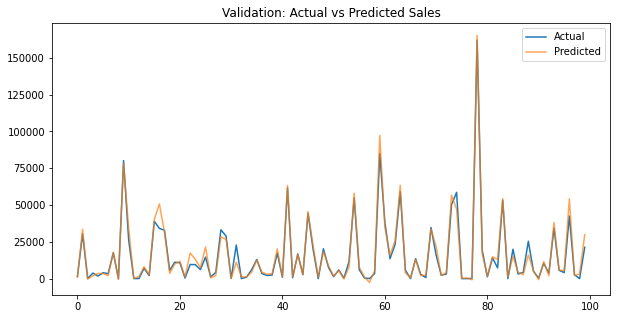

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(y_val.values[:100], label='Actual')
plt.plot(ensemble_val_preds[:100], label='Predicted', alpha=0.7)
plt.title("Validation: Actual vs Predicted Sales")
plt.legend()
plt.show()


In [9]:
from lightgbm import LGBMRegressor, early_stopping, log_evaluation

lgb_model_es = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42
)

# Use callbacks instead of early_stopping_rounds
lgb_model_es.fit(
    X_train_sub, y_train_sub,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=50)
    ]
)

# Predict & Evaluate
lgb_es_preds = lgb_model_es.predict(X_val)
rmse_es = np.sqrt(mean_squared_error(y_val, lgb_es_preds))
mae_es  = mean_absolute_error(y_val, lgb_es_preds)

print(f"\n📊 Early Stopping - RMSE: {rmse_es:.2f}, MAE: {mae_es:.2f}")


Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 7465.57	valid_0's l2: 5.57347e+07
[100]	valid_0's rmse: 6287.43	valid_0's l2: 3.95317e+07
[150]	valid_0's rmse: 5913.79	valid_0's l2: 3.49729e+07
[200]	valid_0's rmse: 5640.83	valid_0's l2: 3.1819e+07
[250]	valid_0's rmse: 5489.89	valid_0's l2: 3.01389e+07
[300]	valid_0's rmse: 5358.02	valid_0's l2: 2.87084e+07
[350]	valid_0's rmse: 5203.97	valid_0's l2: 2.70813e+07
[400]	valid_0's rmse: 5115.62	valid_0's l2: 2.61695e+07
[450]	valid_0's rmse: 5011.51	valid_0's l2: 2.51152e+07
[500]	valid_0's rmse: 4925.6	valid_0's l2: 2.42616e+07
[550]	valid_0's rmse: 4838.07	valid_0's l2: 2.34069e+07
[600]	valid_0's rmse: 4766.32	valid_0's l2: 2.27178e+07
[650]	valid_0's rmse: 4684.34	valid_0's l2: 2.1943e+07
[700]	valid_0's rmse: 4582.75	valid_0's l2: 2.10016e+07
[750]	valid_0's rmse: 4514.41	valid_0's l2: 2.03799e+07
[800]	valid_0's rmse: 4451.15	valid_0's l2: 1.98128e+07
[850]	valid_0's rmse: 4409.73	valid_0's l2: 1.9

In [10]:
from lightgbm import LGBMRegressor, early_stopping, log_evaluation

# 1. Define model with many boosting rounds (epochs)
lgb_model_epoch = LGBMRegressor(
    n_estimators=1000,        # Number of "epochs"
    learning_rate=0.05,
    num_leaves=31,
    random_state=42
)

# 2. Fit with evaluation logging
lgb_model_epoch.fit(
    X_train_sub, y_train_sub,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=25)  # Log every 25 iterations
    ]
)

# 3. Predict and evaluate
lgb_epoch_preds = lgb_model_epoch.predict(X_val)
lgb_rmse = np.sqrt(mean_squared_error(y_val, lgb_epoch_preds))
lgb_mae = mean_absolute_error(y_val, lgb_epoch_preds)

print(f"\n📊 LightGBM Epoch RMSE: {lgb_rmse:.2f}, MAE: {lgb_mae:.2f}")


Training until validation scores don't improve for 50 rounds
[25]	valid_0's rmse: 9829.79	valid_0's l2: 9.66248e+07
[50]	valid_0's rmse: 7465.57	valid_0's l2: 5.57347e+07
[75]	valid_0's rmse: 6633.25	valid_0's l2: 4.4e+07
[100]	valid_0's rmse: 6287.43	valid_0's l2: 3.95317e+07
[125]	valid_0's rmse: 6063.87	valid_0's l2: 3.67705e+07
[150]	valid_0's rmse: 5913.79	valid_0's l2: 3.49729e+07
[175]	valid_0's rmse: 5735	valid_0's l2: 3.28902e+07
[200]	valid_0's rmse: 5640.83	valid_0's l2: 3.1819e+07
[225]	valid_0's rmse: 5561.36	valid_0's l2: 3.09288e+07
[250]	valid_0's rmse: 5489.89	valid_0's l2: 3.01389e+07
[275]	valid_0's rmse: 5411.3	valid_0's l2: 2.92821e+07
[300]	valid_0's rmse: 5358.02	valid_0's l2: 2.87084e+07
[325]	valid_0's rmse: 5259.76	valid_0's l2: 2.76651e+07
[350]	valid_0's rmse: 5203.97	valid_0's l2: 2.70813e+07
[375]	valid_0's rmse: 5149.33	valid_0's l2: 2.65156e+07
[400]	valid_0's rmse: 5115.62	valid_0's l2: 2.61695e+07
[425]	valid_0's rmse: 5065.44	valid_0's l2: 2.56586e+07

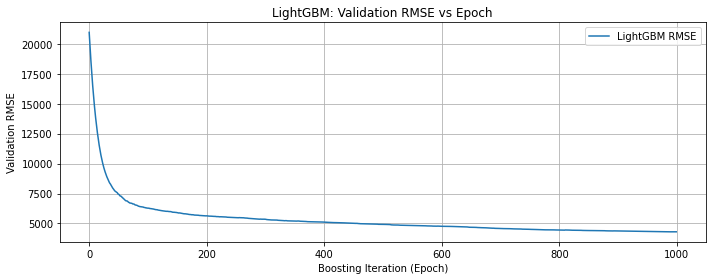

In [11]:
evals_result = lgb_model_epoch.evals_result_

plt.figure(figsize=(10, 4))
plt.plot(evals_result['valid_0']['rmse'], label='LightGBM RMSE')
plt.xlabel("Boosting Iteration (Epoch)")
plt.ylabel("Validation RMSE")
plt.title("LightGBM: Validation RMSE vs Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
!pip install --user --upgrade xgboost


In [18]:
# 1) After you fit your two models and build the ensemble:
lgb_val_preds      = lgb_model.predict(X_val)
xgb_val_preds      = xgb_model.predict(X_val)
ensemble_val_preds = 0.5*lgb_val_preds + 0.5*xgb_val_preds

# 2) Now import and compute all four metrics:
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error
)
import numpy as np

mse  = mean_squared_error(y_val, ensemble_val_preds)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_val, ensemble_val_preds)
r2   = r2_score(y_val, ensemble_val_preds)
mape = mean_absolute_percentage_error(y_val, ensemble_val_preds)

print(f"Validation → RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.3f}, MAPE: {100*mape:.2f}%")


Validation → RMSE: 4671.35, MAE: 2815.58, R²: 0.954, MAPE: 36606819904649864.00%


In [23]:
from statsmodels.tsa.stattools import adfuller, kpss

print("ADF p-value:", adfuller(train_ts)[1])
print("KPSS p-value:", kpss(train_ts, regression='c')[1])


ADF p-value: 9.063916855404282e-07
KPSS p-value: 0.1


/scratch/tvadde/6337467/ipykernel_1913373/497477085.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  print("KPSS p-value:", kpss(train_ts, regression='c')[1])


In [22]:
# 1) Make sure you still have a DataFrame or Series called `df` 
#    with a DateTimeIndex and a column “sales”

# 2) Re‐aggregate it to weekly totals (Monday boundary)…
weekly = df['sales'].resample('W-MON').sum()

# 3) Then split‐off the last 12 weeks as your hold-out:
train_ts = weekly.iloc[:-12]
test_ts  = weekly.iloc[-12:]


In [21]:
from statsmodels.tsa.stattools import adfuller, kpss

# 1) (Re)load & preprocess just enough to get df['sales'] as a time series:
import pandas as pd

# load
train    = pd.read_csv('train.csv',    parse_dates=['Date'])
features = pd.read_csv('features.csv', parse_dates=['Date'])
stores   = pd.read_csv('stores.csv')

# merge & rename
df = (
    train
    .merge(features, on=['Store','Date'], how='left')
    .merge(stores,  on='Store',        how='left')
    .rename(columns={'Weekly_Sales':'sales'})
)
# drop the duplicate holiday flag
df = df.drop(columns=['IsHoliday_y']).rename(columns={'IsHoliday_x':'IsHoliday'})
df['sales'] = df['sales'].astype(float)

# 2) set the Date index
df.set_index('Date', inplace=True)

# 3) aggregate to weekly totals (Monday boundary)
weekly  = df['sales'].resample('W-MON').sum()

# 4) split off the last 12 weeks
train_ts = weekly.iloc[:-12]
test_ts  = weekly.iloc[-12:]


In [24]:
full['is_month_end'] = full['Date'].dt.is_month_end.astype(int)
full['quarter']      = full['Date'].dt.quarter


In [29]:
import optuna
import numpy as np
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

def objective(trial):
    # 1) Sample hyper-parameters
    params = {
        "n_estimators":     trial.suggest_int   ("n_estimators",     200, 1000),
        "learning_rate":    trial.suggest_float ("learning_rate",   1e-3, 1e-1, log=True),
        "num_leaves":       trial.suggest_int   ("num_leaves",       16,   64),
        "feature_fraction": trial.suggest_float ("feature_fraction", 0.5,  1.0),
        "bagging_fraction": trial.suggest_float ("bagging_fraction", 0.5,  1.0),
        "random_state":     42,
        "verbosity":       -1,
    }

    # 2) TimeSeries CV
    tscv = TimeSeriesSplit(n_splits=3)
    fold_rmses = []

    for train_idx, valid_idx in tscv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        # 3) Build & fit with callbacks instead of early_stopping_rounds kw
        model = LGBMRegressor(**params)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            eval_metric="rmse",
            callbacks=[
                early_stopping(stopping_rounds=50),
                log_evaluation(period=0)
            ]
        )

        # 4) Predict & score
        preds = model.predict(X_val)
        fold_rmses.append(np.sqrt(mean_squared_error(y_val, preds)))

    # 5) Return average RMSE
    return float(np.mean(fold_rmses))

# — Make sure you’ve already done:
#    X_train, y_train = …   (your preprocessed features & target)

# 6) Run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("✅ Best hyperparameters:", study.best_params)


[I 2025-05-06 19:54:42,435] A new study created in memory with name: no-name-cea77351-93c2-438f-9d0c-cc0007156a18


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[775]	valid_0's rmse: 14803.8	valid_0's l2: 2.19152e+08
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[775]	valid_0's rmse: 14157.6	valid_0's l2: 2.00439e+08
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[775]	valid_0's rmse: 12522.2	valid_0's l2: 1.56806e+08


[I 2025-05-06 19:55:42,825] Trial 0 finished with value: 13827.89106711939 and parameters: {'n_estimators': 775, 'learning_rate': 0.0010352831911585954, 'num_leaves': 53, 'feature_fraction': 0.6852164226289044, 'bagging_fraction': 0.7495636311559566}. Best is trial 0 with value: 13827.89106711939.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[521]	valid_0's rmse: 9727.91	valid_0's l2: 9.46323e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[523]	valid_0's rmse: 5662.04	valid_0's l2: 3.20587e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[523]	valid_0's rmse: 5008.31	valid_0's l2: 2.50832e+07


[I 2025-05-06 19:56:07,834] Trial 1 finished with value: 6799.42297275631 and parameters: {'n_estimators': 523, 'learning_rate': 0.05190203744927319, 'num_leaves': 29, 'feature_fraction': 0.7329453050385262, 'bagging_fraction': 0.943718696618699}. Best is trial 1 with value: 6799.42297275631.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[307]	valid_0's rmse: 18438.8	valid_0's l2: 3.39988e+08
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[307]	valid_0's rmse: 18246.5	valid_0's l2: 3.32936e+08
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[307]	valid_0's rmse: 16677	valid_0's l2: 2.78122e+08


[I 2025-05-06 19:56:35,136] Trial 2 finished with value: 17787.43902666525 and parameters: {'n_estimators': 307, 'learning_rate': 0.0011490549723995043, 'num_leaves': 63, 'feature_fraction': 0.8228322300903927, 'bagging_fraction': 0.8457175249342423}. Best is trial 1 with value: 6799.42297275631.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[306]	valid_0's rmse: 9699.74	valid_0's l2: 9.4085e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[306]	valid_0's rmse: 5299.71	valid_0's l2: 2.80869e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[305]	valid_0's rmse: 4586	valid_0's l2: 2.10314e+07


[I 2025-05-06 19:56:53,173] Trial 3 finished with value: 6528.483835324631 and parameters: {'n_estimators': 306, 'learning_rate': 0.08230230324584126, 'num_leaves': 50, 'feature_fraction': 0.8567961326307524, 'bagging_fraction': 0.918424527598545}. Best is trial 3 with value: 6528.483835324631.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[484]	valid_0's rmse: 9847.98	valid_0's l2: 9.69827e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[484]	valid_0's rmse: 6421.9	valid_0's l2: 4.12408e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[484]	valid_0's rmse: 5675.31	valid_0's l2: 3.22091e+07


[I 2025-05-06 19:57:25,099] Trial 4 finished with value: 7315.064184158019 and parameters: {'n_estimators': 484, 'learning_rate': 0.013989125102738604, 'num_leaves': 46, 'feature_fraction': 0.6106449444965527, 'bagging_fraction': 0.6681225555697075}. Best is trial 3 with value: 6528.483835324631.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[907]	valid_0's rmse: 11211	valid_0's l2: 1.25686e+08
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[907]	valid_0's rmse: 9510.7	valid_0's l2: 9.04535e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[907]	valid_0's rmse: 7902.65	valid_0's l2: 6.24519e+07


[I 2025-05-06 19:58:25,906] Trial 5 finished with value: 9541.443293367847 and parameters: {'n_estimators': 907, 'learning_rate': 0.002550146405134528, 'num_leaves': 32, 'feature_fraction': 0.9873473984556562, 'bagging_fraction': 0.6929215917125671}. Best is trial 3 with value: 6528.483835324631.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[553]	valid_0's rmse: 12012.9	valid_0's l2: 1.4431e+08
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[553]	valid_0's rmse: 10693.4	valid_0's l2: 1.14349e+08
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[553]	valid_0's rmse: 9078.4	valid_0's l2: 8.24173e+07


[I 2025-05-06 19:59:09,196] Trial 6 finished with value: 10594.907088438014 and parameters: {'n_estimators': 553, 'learning_rate': 0.002713050611040888, 'num_leaves': 46, 'feature_fraction': 0.7491396813418161, 'bagging_fraction': 0.7635853660840577}. Best is trial 3 with value: 6528.483835324631.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[814]	valid_0's rmse: 14311.3	valid_0's l2: 2.04813e+08
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[814]	valid_0's rmse: 13549.9	valid_0's l2: 1.83601e+08
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[814]	valid_0's rmse: 11947.1	valid_0's l2: 1.42733e+08


[I 2025-05-06 20:00:16,906] Trial 7 finished with value: 13269.44051413903 and parameters: {'n_estimators': 814, 'learning_rate': 0.001059637802808891, 'num_leaves': 56, 'feature_fraction': 0.7718037675973834, 'bagging_fraction': 0.5433289575463719}. Best is trial 3 with value: 6528.483835324631.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[767]	valid_0's rmse: 9709.19	valid_0's l2: 9.42683e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[767]	valid_0's rmse: 6073.94	valid_0's l2: 3.68927e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[767]	valid_0's rmse: 5309.15	valid_0's l2: 2.81871e+07


[I 2025-05-06 20:01:04,352] Trial 8 finished with value: 7030.759010483728 and parameters: {'n_estimators': 767, 'learning_rate': 0.011854432255651207, 'num_leaves': 51, 'feature_fraction': 0.5774053851241892, 'bagging_fraction': 0.8870575737350972}. Best is trial 3 with value: 6528.483835324631.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[491]	valid_0's rmse: 9492.6	valid_0's l2: 9.01094e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[882]	valid_0's rmse: 4656.57	valid_0's l2: 2.16837e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[883]	valid_0's rmse: 4003.31	valid_0's l2: 1.60265e+07


[I 2025-05-06 20:01:40,717] Trial 9 finished with value: 6050.826029488184 and parameters: {'n_estimators': 883, 'learning_rate': 0.08645000908520122, 'num_leaves': 48, 'feature_fraction': 0.6972985801953733, 'bagging_fraction': 0.6623360073940474}. Best is trial 9 with value: 6050.826029488184.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[943]	valid_0's rmse: 9981.15	valid_0's l2: 9.96235e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[943]	valid_0's rmse: 6217.82	valid_0's l2: 3.86613e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[943]	valid_0's rmse: 5561.86	valid_0's l2: 3.09343e+07


[I 2025-05-06 20:02:18,879] Trial 10 finished with value: 7253.611500579573 and parameters: {'n_estimators': 943, 'learning_rate': 0.03058931743316888, 'num_leaves': 16, 'feature_fraction': 0.9202592676191406, 'bagging_fraction': 0.5373975193292134}. Best is trial 9 with value: 6050.826029488184.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[210]	valid_0's rmse: 9717.41	valid_0's l2: 9.44281e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[210]	valid_0's rmse: 5706.25	valid_0's l2: 3.25613e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[210]	valid_0's rmse: 5048.54	valid_0's l2: 2.54877e+07


[I 2025-05-06 20:02:31,473] Trial 11 finished with value: 6824.065413954243 and parameters: {'n_estimators': 210, 'learning_rate': 0.08960272395734202, 'num_leaves': 39, 'feature_fraction': 0.8446499692842939, 'bagging_fraction': 0.970985711885744}. Best is trial 9 with value: 6050.826029488184.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[363]	valid_0's rmse: 9507.38	valid_0's l2: 9.03904e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[363]	valid_0's rmse: 5098.79	valid_0's l2: 2.59977e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[363]	valid_0's rmse: 4324.68	valid_0's l2: 1.87029e+07


[I 2025-05-06 20:02:51,727] Trial 12 finished with value: 6310.286090136232 and parameters: {'n_estimators': 363, 'learning_rate': 0.0795900169338675, 'num_leaves': 63, 'feature_fraction': 0.5222678220866837, 'bagging_fraction': 0.6245944056137391}. Best is trial 9 with value: 6050.826029488184.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[664]	valid_0's rmse: 9462.11	valid_0's l2: 8.95315e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[664]	valid_0's rmse: 5354.76	valid_0's l2: 2.86735e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[663]	valid_0's rmse: 4628.97	valid_0's l2: 2.14273e+07


[I 2025-05-06 20:03:30,878] Trial 13 finished with value: 6481.943827466389 and parameters: {'n_estimators': 664, 'learning_rate': 0.027895259068732074, 'num_leaves': 62, 'feature_fraction': 0.5477351191751102, 'bagging_fraction': 0.6190262762972814}. Best is trial 9 with value: 6050.826029488184.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[448]	valid_0's rmse: 9691.49	valid_0's l2: 9.39249e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[448]	valid_0's rmse: 5870.37	valid_0's l2: 3.44613e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[448]	valid_0's rmse: 5187.74	valid_0's l2: 2.69127e+07


[I 2025-05-06 20:03:55,395] Trial 14 finished with value: 6916.532955937528 and parameters: {'n_estimators': 448, 'learning_rate': 0.03619496483613283, 'num_leaves': 38, 'feature_fraction': 0.6524614421067758, 'bagging_fraction': 0.585463698661234}. Best is trial 9 with value: 6050.826029488184.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[646]	valid_0's rmse: 9469.63	valid_0's l2: 8.96738e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[657]	valid_0's rmse: 4703.42	valid_0's l2: 2.21222e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[657]	valid_0's rmse: 3991.81	valid_0's l2: 1.59345e+07


[I 2025-05-06 20:04:25,750] Trial 15 finished with value: 6054.952098198067 and parameters: {'n_estimators': 657, 'learning_rate': 0.09850513761838309, 'num_leaves': 58, 'feature_fraction': 0.5054393977942988, 'bagging_fraction': 0.6372968159009383}. Best is trial 9 with value: 6050.826029488184.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[639]	valid_0's rmse: 10122.7	valid_0's l2: 1.02469e+08
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[639]	valid_0's rmse: 7296.57	valid_0's l2: 5.32399e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[639]	valid_0's rmse: 6305.24	valid_0's l2: 3.9756e+07


[I 2025-05-06 20:05:09,563] Trial 16 finished with value: 7908.164280433743 and parameters: {'n_estimators': 639, 'learning_rate': 0.006087132181009109, 'num_leaves': 57, 'feature_fraction': 0.5027536202416178, 'bagging_fraction': 0.7322993196313973}. Best is trial 9 with value: 6050.826029488184.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[861]	valid_0's rmse: 9603.6	valid_0's l2: 9.22291e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[864]	valid_0's rmse: 5777.02	valid_0's l2: 3.3374e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[865]	valid_0's rmse: 5078.74	valid_0's l2: 2.57935e+07


[I 2025-05-06 20:05:57,452] Trial 17 finished with value: 6819.785595423841 and parameters: {'n_estimators': 865, 'learning_rate': 0.017562100160536897, 'num_leaves': 45, 'feature_fraction': 0.6350591280542207, 'bagging_fraction': 0.8207390756339812}. Best is trial 9 with value: 6050.826029488184.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[983]	valid_0's rmse: 9501.9	valid_0's l2: 9.0286e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[991]	valid_0's rmse: 4875.46	valid_0's l2: 2.37701e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[993]	valid_0's rmse: 4115.35	valid_0's l2: 1.69361e+07


[I 2025-05-06 20:06:46,123] Trial 18 finished with value: 6164.233256317242 and parameters: {'n_estimators': 993, 'learning_rate': 0.04590555702902671, 'num_leaves': 58, 'feature_fraction': 0.6910816657217921, 'bagging_fraction': 0.6687876770202066}. Best is trial 9 with value: 6050.826029488184.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[681]	valid_0's rmse: 10293.1	valid_0's l2: 1.05948e+08
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[681]	valid_0's rmse: 7620.6	valid_0's l2: 5.80736e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[681]	valid_0's rmse: 6635.45	valid_0's l2: 4.40293e+07


[I 2025-05-06 20:07:27,244] Trial 19 finished with value: 8183.049118865946 and parameters: {'n_estimators': 681, 'learning_rate': 0.006410427128282605, 'num_leaves': 33, 'feature_fraction': 0.5893923079790574, 'bagging_fraction': 0.5138580255587539}. Best is trial 9 with value: 6050.826029488184.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[745]	valid_0's rmse: 10071.9	valid_0's l2: 1.01442e+08
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[745]	valid_0's rmse: 6400.19	valid_0's l2: 4.09624e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[745]	valid_0's rmse: 5687.06	valid_0's l2: 3.23426e+07


[I 2025-05-06 20:08:04,211] Trial 20 finished with value: 7386.367617412892 and parameters: {'n_estimators': 745, 'learning_rate': 0.021718201190141836, 'num_leaves': 24, 'feature_fraction': 0.9041050294405122, 'bagging_fraction': 0.7968905649445106}. Best is trial 9 with value: 6050.826029488184.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[965]	valid_0's rmse: 9419.01	valid_0's l2: 8.87177e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[965]	valid_0's rmse: 4786.12	valid_0's l2: 2.2907e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[964]	valid_0's rmse: 4115.16	valid_0's l2: 1.69346e+07


[I 2025-05-06 20:08:51,487] Trial 21 finished with value: 6106.7644257711245 and parameters: {'n_estimators': 965, 'learning_rate': 0.05144399966338567, 'num_leaves': 58, 'feature_fraction': 0.6919663588483279, 'bagging_fraction': 0.6772475984672796}. Best is trial 9 with value: 6050.826029488184.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[859]	valid_0's rmse: 9450.25	valid_0's l2: 8.93073e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[861]	valid_0's rmse: 4811.17	valid_0's l2: 2.31473e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[860]	valid_0's rmse: 4174.4	valid_0's l2: 1.74256e+07


[I 2025-05-06 20:09:34,331] Trial 22 finished with value: 6145.273558321375 and parameters: {'n_estimators': 861, 'learning_rate': 0.052868168487601515, 'num_leaves': 58, 'feature_fraction': 0.683847431276535, 'bagging_fraction': 0.7048199538091907}. Best is trial 9 with value: 6050.826029488184.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[612]	valid_0's rmse: 9545.83	valid_0's l2: 9.11229e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[995]	valid_0's rmse: 4744.95	valid_0's l2: 2.25146e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[995]	valid_0's rmse: 4025.91	valid_0's l2: 1.62079e+07


[I 2025-05-06 20:10:17,913] Trial 23 finished with value: 6105.5644221286975 and parameters: {'n_estimators': 995, 'learning_rate': 0.06520807009036975, 'num_leaves': 49, 'feature_fraction': 0.7845379917376968, 'bagging_fraction': 0.6127477023753476}. Best is trial 9 with value: 6050.826029488184.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[875]	valid_0's rmse: 9515.21	valid_0's l2: 9.05393e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[875]	valid_0's rmse: 4734.21	valid_0's l2: 2.24127e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[875]	valid_0's rmse: 4016.14	valid_0's l2: 1.61294e+07


[I 2025-05-06 20:10:56,628] Trial 24 finished with value: 6088.518681254561 and parameters: {'n_estimators': 875, 'learning_rate': 0.0987650117230198, 'num_leaves': 42, 'feature_fraction': 0.8092385905528583, 'bagging_fraction': 0.5955157270009441}. Best is trial 9 with value: 6050.826029488184.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[713]	valid_0's rmse: 9610.7	valid_0's l2: 9.23656e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[719]	valid_0's rmse: 4835.07	valid_0's l2: 2.33779e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[719]	valid_0's rmse: 4149.26	valid_0's l2: 1.72164e+07


[I 2025-05-06 20:11:29,290] Trial 25 finished with value: 6198.3439233174395 and parameters: {'n_estimators': 719, 'learning_rate': 0.09644333107810714, 'num_leaves': 42, 'feature_fraction': 0.8056784511393615, 'bagging_fraction': 0.5734770303738641}. Best is trial 9 with value: 6050.826029488184.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[598]	valid_0's rmse: 9757.44	valid_0's l2: 9.52077e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[598]	valid_0's rmse: 5544.24	valid_0's l2: 3.07386e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[598]	valid_0's rmse: 4859.75	valid_0's l2: 2.36172e+07


[I 2025-05-06 20:12:02,481] Trial 26 finished with value: 6720.479106770035 and parameters: {'n_estimators': 598, 'learning_rate': 0.03561447256133449, 'num_leaves': 43, 'feature_fraction': 0.8792249103792451, 'bagging_fraction': 0.6372025448575036}. Best is trial 9 with value: 6050.826029488184.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[827]	valid_0's rmse: 9517.01	valid_0's l2: 9.05736e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[828]	valid_0's rmse: 4751.32	valid_0's l2: 2.2575e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[828]	valid_0's rmse: 4030.83	valid_0's l2: 1.62476e+07


[I 2025-05-06 20:12:42,249] Trial 27 finished with value: 6099.7212853182355 and parameters: {'n_estimators': 828, 'learning_rate': 0.06821012335648267, 'num_leaves': 54, 'feature_fraction': 0.7151822247261955, 'bagging_fraction': 0.5847632819114391}. Best is trial 9 with value: 6050.826029488184.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[898]	valid_0's rmse: 10204.3	valid_0's l2: 1.04128e+08
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[899]	valid_0's rmse: 6682.37	valid_0's l2: 4.46541e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[899]	valid_0's rmse: 5940.15	valid_0's l2: 3.52854e+07


[I 2025-05-06 20:13:38,558] Trial 28 finished with value: 7608.945433164078 and parameters: {'n_estimators': 899, 'learning_rate': 0.007578557764961548, 'num_leaves': 36, 'feature_fraction': 0.9540451786427058, 'bagging_fraction': 0.6455741532748364}. Best is trial 9 with value: 6050.826029488184.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[799]	valid_0's rmse: 9532.35	valid_0's l2: 9.08658e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[799]	valid_0's rmse: 5536.29	valid_0's l2: 3.06506e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[799]	valid_0's rmse: 4753.15	valid_0's l2: 2.25925e+07


[I 2025-05-06 20:14:22,958] Trial 29 finished with value: 6607.2670888962675 and parameters: {'n_estimators': 799, 'learning_rate': 0.021969150597179982, 'num_leaves': 52, 'feature_fraction': 0.5513424269008066, 'bagging_fraction': 0.7230079140952278}. Best is trial 9 with value: 6050.826029488184.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[717]	valid_0's rmse: 9561.71	valid_0's l2: 9.14262e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[709]	valid_0's rmse: 4738.73	valid_0's l2: 2.24556e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[717]	valid_0's rmse: 4072.24	valid_0's l2: 1.65832e+07


[I 2025-05-06 20:14:56,850] Trial 30 finished with value: 6124.227380926943 and parameters: {'n_estimators': 717, 'learning_rate': 0.0972014660457381, 'num_leaves': 48, 'feature_fraction': 0.7681771005415304, 'bagging_fraction': 0.5608199764564394}. Best is trial 9 with value: 6050.826029488184.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[824]	valid_0's rmse: 9413.21	valid_0's l2: 8.86086e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[832]	valid_0's rmse: 4736.6	valid_0's l2: 2.24354e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[832]	valid_0's rmse: 4117.22	valid_0's l2: 1.69515e+07


[I 2025-05-06 20:15:36,700] Trial 31 finished with value: 6089.010948323561 and parameters: {'n_estimators': 832, 'learning_rate': 0.06936381344663803, 'num_leaves': 55, 'feature_fraction': 0.7237287385656815, 'bagging_fraction': 0.5022780268391078}. Best is trial 9 with value: 6050.826029488184.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[874]	valid_0's rmse: 9479.03	valid_0's l2: 8.98519e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[877]	valid_0's rmse: 4702.29	valid_0's l2: 2.21116e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[877]	valid_0's rmse: 4080.81	valid_0's l2: 1.6653e+07


[I 2025-05-06 20:16:19,172] Trial 32 finished with value: 6087.375576242288 and parameters: {'n_estimators': 877, 'learning_rate': 0.06360642540867255, 'num_leaves': 54, 'feature_fraction': 0.726520025741043, 'bagging_fraction': 0.50631025046623}. Best is trial 9 with value: 6050.826029488184.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[905]	valid_0's rmse: 9536.9	valid_0's l2: 9.09525e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[905]	valid_0's rmse: 4938.47	valid_0's l2: 2.43885e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[905]	valid_0's rmse: 4204.51	valid_0's l2: 1.76779e+07


[I 2025-05-06 20:17:07,135] Trial 33 finished with value: 6226.626623174835 and parameters: {'n_estimators': 905, 'learning_rate': 0.04248197288316878, 'num_leaves': 60, 'feature_fraction': 0.8132586723477124, 'bagging_fraction': 0.5969513899713962}. Best is trial 9 with value: 6050.826029488184.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[934]	valid_0's rmse: 9463.05	valid_0's l2: 8.95492e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[933]	valid_0's rmse: 4730.26	valid_0's l2: 2.23754e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[934]	valid_0's rmse: 4094.84	valid_0's l2: 1.67678e+07


[I 2025-05-06 20:17:50,148] Trial 34 finished with value: 6096.049745892585 and parameters: {'n_estimators': 934, 'learning_rate': 0.058104499131779154, 'num_leaves': 53, 'feature_fraction': 0.649401101855662, 'bagging_fraction': 0.5335985048513912}. Best is trial 9 with value: 6050.826029488184.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[860]	valid_0's rmse: 9579.11	valid_0's l2: 9.17593e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[860]	valid_0's rmse: 4666.59	valid_0's l2: 2.1777e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[860]	valid_0's rmse: 3960.06	valid_0's l2: 1.56821e+07


[I 2025-05-06 20:18:28,410] Trial 35 finished with value: 6068.58549367535 and parameters: {'n_estimators': 860, 'learning_rate': 0.09945086501063023, 'num_leaves': 42, 'feature_fraction': 0.8453000702332684, 'bagging_fraction': 0.7698086903863413}. Best is trial 9 with value: 6050.826029488184.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[771]	valid_0's rmse: 9628.04	valid_0's l2: 9.26992e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[785]	valid_0's rmse: 4851.1	valid_0's l2: 2.35332e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[785]	valid_0's rmse: 4088.23	valid_0's l2: 1.67137e+07


[I 2025-05-06 20:19:06,991] Trial 36 finished with value: 6189.124523338761 and parameters: {'n_estimators': 785, 'learning_rate': 0.06932284597654184, 'num_leaves': 48, 'feature_fraction': 0.868088810638424, 'bagging_fraction': 0.749621509785008}. Best is trial 9 with value: 6050.826029488184.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[554]	valid_0's rmse: 9631.52	valid_0's l2: 9.27662e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[557]	valid_0's rmse: 5445.24	valid_0's l2: 2.96507e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[556]	valid_0's rmse: 4734.09	valid_0's l2: 2.24116e+07


[I 2025-05-06 20:19:37,208] Trial 37 finished with value: 6603.618499989887 and parameters: {'n_estimators': 557, 'learning_rate': 0.041642951862734444, 'num_leaves': 45, 'feature_fraction': 0.7439072547021541, 'bagging_fraction': 0.8480133228585582}. Best is trial 9 with value: 6050.826029488184.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[592]	valid_0's rmse: 9618.42	valid_0's l2: 9.25139e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[738]	valid_0's rmse: 4922.14	valid_0's l2: 2.42274e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[738]	valid_0's rmse: 4133.78	valid_0's l2: 1.70881e+07


[I 2025-05-06 20:20:12,502] Trial 38 finished with value: 6224.777504475352 and parameters: {'n_estimators': 739, 'learning_rate': 0.07609875262728281, 'num_leaves': 51, 'feature_fraction': 0.8325837082767483, 'bagging_fraction': 0.7923500400193849}. Best is trial 9 with value: 6050.826029488184.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[447]	valid_0's rmse: 9787.04	valid_0's l2: 9.57862e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[448]	valid_0's rmse: 5170.39	valid_0's l2: 2.67329e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[448]	valid_0's rmse: 4392.34	valid_0's l2: 1.92926e+07


[I 2025-05-06 20:20:39,985] Trial 39 finished with value: 6449.9229449123995 and parameters: {'n_estimators': 448, 'learning_rate': 0.058583637244481374, 'num_leaves': 61, 'feature_fraction': 0.981653525276547, 'bagging_fraction': 0.7752514542005344}. Best is trial 9 with value: 6050.826029488184.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[619]	valid_0's rmse: 12912	valid_0's l2: 1.66721e+08
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[619]	valid_0's rmse: 11759.4	valid_0's l2: 1.38283e+08
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[619]	valid_0's rmse: 10196.5	valid_0's l2: 1.03968e+08


[I 2025-05-06 20:21:27,324] Trial 40 finished with value: 11622.626413512218 and parameters: {'n_estimators': 619, 'learning_rate': 0.001942669723139525, 'num_leaves': 64, 'feature_fraction': 0.5996964509539978, 'bagging_fraction': 0.7088925240669682}. Best is trial 9 with value: 6050.826029488184.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[869]	valid_0's rmse: 9540.02	valid_0's l2: 9.1012e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[873]	valid_0's rmse: 4762.77	valid_0's l2: 2.26839e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[873]	valid_0's rmse: 4091.37	valid_0's l2: 1.67393e+07


[I 2025-05-06 20:22:06,236] Trial 41 finished with value: 6131.384378496416 and parameters: {'n_estimators': 873, 'learning_rate': 0.08275732482329207, 'num_leaves': 41, 'feature_fraction': 0.7965043520865159, 'bagging_fraction': 0.6520490317837152}. Best is trial 9 with value: 6050.826029488184.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[937]	valid_0's rmse: 9536.57	valid_0's l2: 9.09461e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[936]	valid_0's rmse: 4688.17	valid_0's l2: 2.19789e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[937]	valid_0's rmse: 3951.21	valid_0's l2: 1.5612e+07


[I 2025-05-06 20:22:45,159] Trial 42 finished with value: 6058.648972956952 and parameters: {'n_estimators': 937, 'learning_rate': 0.09899739421635567, 'num_leaves': 35, 'feature_fraction': 0.7724534209973918, 'bagging_fraction': 0.6888668055955828}. Best is trial 9 with value: 6050.826029488184.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[923]	valid_0's rmse: 9510.88	valid_0's l2: 9.04568e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[930]	valid_0's rmse: 4826.01	valid_0's l2: 2.32904e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[927]	valid_0's rmse: 4146.01	valid_0's l2: 1.71894e+07


[I 2025-05-06 20:23:24,150] Trial 43 finished with value: 6160.965973634516 and parameters: {'n_estimators': 930, 'learning_rate': 0.07934081887268034, 'num_leaves': 31, 'feature_fraction': 0.754332763713809, 'bagging_fraction': 0.6904900903512723}. Best is trial 9 with value: 6050.826029488184.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[633]	valid_0's rmse: 9680.99	valid_0's l2: 9.37215e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[956]	valid_0's rmse: 4876.71	valid_0's l2: 2.37823e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[960]	valid_0's rmse: 4141.56	valid_0's l2: 1.71525e+07


[I 2025-05-06 20:24:01,067] Trial 44 finished with value: 6233.0863853230885 and parameters: {'n_estimators': 961, 'learning_rate': 0.09877207531576583, 'num_leaves': 27, 'feature_fraction': 0.8902347113232117, 'bagging_fraction': 0.724771342414546}. Best is trial 9 with value: 6050.826029488184.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[840]	valid_0's rmse: 9532.79	valid_0's l2: 9.08741e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[837]	valid_0's rmse: 4971.39	valid_0's l2: 2.47147e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[841]	valid_0's rmse: 4308.96	valid_0's l2: 1.85672e+07


[I 2025-05-06 20:24:38,197] Trial 45 finished with value: 6271.048488015954 and parameters: {'n_estimators': 841, 'learning_rate': 0.06250212124996656, 'num_leaves': 36, 'feature_fraction': 0.7118773949647196, 'bagging_fraction': 0.8477894910623787}. Best is trial 9 with value: 6050.826029488184.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[787]	valid_0's rmse: 9679.7	valid_0's l2: 9.36965e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[787]	valid_0's rmse: 5712.54	valid_0's l2: 3.26331e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[787]	valid_0's rmse: 4919.78	valid_0's l2: 2.42043e+07


[I 2025-05-06 20:25:16,777] Trial 46 finished with value: 6770.673511175669 and parameters: {'n_estimators': 787, 'learning_rate': 0.028248940318267766, 'num_leaves': 37, 'feature_fraction': 0.6267596087980519, 'bagging_fraction': 0.8816054270052942}. Best is trial 9 with value: 6050.826029488184.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[896]	valid_0's rmse: 9612.8	valid_0's l2: 9.24058e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[897]	valid_0's rmse: 4930.61	valid_0's l2: 2.4311e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[897]	valid_0's rmse: 4288.34	valid_0's l2: 1.83898e+07


[I 2025-05-06 20:26:01,769] Trial 47 finished with value: 6277.249696773059 and parameters: {'n_estimators': 897, 'learning_rate': 0.047142400694427, 'num_leaves': 47, 'feature_fraction': 0.8421031550658095, 'bagging_fraction': 0.7598680586308032}. Best is trial 9 with value: 6050.826029488184.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[963]	valid_0's rmse: 9521.83	valid_0's l2: 9.06653e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[963]	valid_0's rmse: 4883.68	valid_0's l2: 2.38503e+07
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[962]	valid_0's rmse: 4183.45	valid_0's l2: 1.75013e+07


[I 2025-05-06 20:26:45,412] Trial 48 finished with value: 6196.32087162026 and parameters: {'n_estimators': 963, 'learning_rate': 0.05543902927916449, 'num_leaves': 44, 'feature_fraction': 0.6675524744490623, 'bagging_fraction': 0.6619882250851485}. Best is trial 9 with value: 6050.826029488184.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[388]	valid_0's rmse: 12101	valid_0's l2: 1.46433e+08
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[388]	valid_0's rmse: 10802.6	valid_0's l2: 1.16697e+08
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[388]	valid_0's rmse: 9236.19	valid_0's l2: 8.53072e+07


[I 2025-05-06 20:27:12,310] Trial 49 finished with value: 10713.261587508021 and parameters: {'n_estimators': 388, 'learning_rate': 0.0041607273218595, 'num_leaves': 40, 'feature_fraction': 0.5612910324471627, 'bagging_fraction': 0.736846180194371}. Best is trial 9 with value: 6050.826029488184.


✅ Best hyperparameters: {'n_estimators': 883, 'learning_rate': 0.08645000908520122, 'num_leaves': 48, 'feature_fraction': 0.6972985801953733, 'bagging_fraction': 0.6623360073940474}


In [30]:
from sklearn.inspection import permutation_importance
r = permutation_importance(lgb_model, X_val, y_val, n_repeats=10, random_state=0)
imp = pd.Series(r.importances_mean, index=X.columns).sort_values()
imp.tail(20).plot.barh(figsize=(6,8))


NameError: name 'X' is not defined

In [ ]:
import shap
explainer   = shap.TreeExplainer(model_full)
shap_vals   = explainer.shap_values(X_train)
shap.summary_plot(shap_vals, X_train, max_display=20)
